In [1]:
import os
import sys
file_path = os.path.abspath('../')
print(file_path)
sys.path.append(file_path)
from CommonUtil import *

/home/gil/gcubme_ai3/Workspace/SB_MUN


In [2]:
import glob
import h5py
import cv2
import numpy as np

from tqdm import tqdm, tqdm_notebook
import shutil
import json
import SimpleITK as sitk
import matplotlib.pylab as plt
from skimage.transform import resize
from datetime import datetime, timedelta, timezone
import nibabel as nib
import SimpleITK as sitk
import pydicom

In [3]:
win_level = 50
win_width = 300
#os.makedirs(save_dir)

In [4]:
width = 128
height = 128
slices = 64
channel = 1

aug_cnt = 10

only_liver_section = True

In [19]:
origin_dir = os.path.abspath('./data/origin_dcm')
print(origin_dir)

save_dir = os.path.abspath(f'./data')
os.makedirs(save_dir, exist_ok=True)

/home/gil/gcubme_ai3/Workspace/SB_MUN/KangSM/data/origin_dcm


# data path 가져오기

In [6]:
pre_list = sorted(glob.glob(f'{origin_dir}/*/*'))
print(len(pre_list), pre_list[0])

4 /home/gil/gcubme_ai3/Workspace/SB_MUN/KangSM/data/origin_dcm/10865183_20110407/0005_20110407_145613


# label

In [7]:
pre_lab = []
for i in tqdm_notebook(range(len(pre_list))):
    pre_dir = pre_list[i]   
    pre_path_list = sorted(glob.glob(f'{pre_dir}/*.nii.gz'))   
    
    if (len(pre_path_list) != 1):
        print(len(pre_path_list))
        continue
    pre_path = pre_path_list[0]
    
    pre_itk =  sitk.ReadImage(pre_path)
    pre_arr = sitk.GetArrayFromImage(pre_itk)
    
#     pre_arr = return_liver_section(pre_arr)
    pre_lab.append(pre_arr)
    print(pre_arr.shape)

/data01/anaconda3/envs/msb_tensor_1_15/lib/python3.6/site-packages/ipykernel_launcher.py:2: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  


  0%|          | 0/4 [00:00<?, ?it/s]

(52, 512, 512)
(61, 512, 512)
(54, 512, 512)
(53, 512, 512)


# CT

In [8]:
def load_dcm(dcm_path_list):
    dcm_arr = []
    for i in range(len(dcm_path_list)):
        dcm_path = dcm_path_list[i]
        ds = pydicom.dcmread(dcm_path)
        data = ct_win(ds, win_level, win_width, 'u1', (0, 255))
        dcm_arr.append(data)
    dcm_arr = np.array(dcm_arr)
    return dcm_arr

In [9]:
pre_img = []
for i in tqdm_notebook(range(len(pre_list))):
    pre_path_list = glob.glob(f'{pre_list[i]}/*.dcm')
    pre_arr = load_dcm(pre_path_list)
    pre_arr = np.flip(pre_arr, 0)
    pre_img.append(pre_arr)
    print(pre_arr.shape)


/data01/anaconda3/envs/msb_tensor_1_15/lib/python3.6/site-packages/ipykernel_launcher.py:2: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  


  0%|          | 0/4 [00:00<?, ?it/s]

(52, 512, 512)
(61, 512, 512)
(54, 512, 512)
(53, 512, 512)


# Preprocessing

In [10]:
def return_liver_section(img_arr, lab_arr):
    ls_img_arr = []
    ls_lab_arr = []
    for i in range(len(img_arr)):
        img_data = img_arr[i]
        lab_data = lab_arr[i]
        
        if img_data.shape != lab_data.shape:
            print('error')
            continue
        
        ls_img_data = []
        ls_lab_data = []
        for j in range(len(img_data)):
            img = img_data[j]
            lab = lab_data[j]
            
            if np.sum(lab) > 0:
                ls_img_data.append(img)
                ls_lab_data.append(lab)
                
        ls_img_data = np.array(ls_img_data)
        ls_lab_data = np.array(ls_lab_data)
        print(img_data.shape, ls_img_data.shape)
        
        ls_img_arr.append(ls_img_data)
        ls_lab_arr.append(ls_lab_data)
    
    return ls_img_arr, ls_lab_arr

In [11]:
if only_liver_section:
    ls_pre_img, ls_pre_lab = return_liver_section(pre_img, pre_lab)
    
    

(52, 512, 512) (35, 512, 512)
(61, 512, 512) (35, 512, 512)
(54, 512, 512) (28, 512, 512)
(53, 512, 512) (39, 512, 512)


In [12]:
# shape 
width
height
slices
def returnArray(img_arr, lab_arr):
    total_img_arr = np.zeros((len(img_arr), slices, height, width, channel))
    total_lab_arr = np.zeros((len(lab_arr), slices, height, width, channel))
    
    for i in tqdm_notebook(range(len(img_arr))):
        img_data = img_arr[i]
        lab_data = lab_arr[i]
        
        if len(img_data) > 64:
            img_data = img_data[:64]
            lab_data = lab_data[:64]
            
        for j in range(len(img_data)):
            img = img_data[j]
            lab = lab_data[j]
            
            img = cv2.normalize(img, None, 0, 255, cv2.NORM_MINMAX)
            lab = cv2.normalize(lab, None, 0, 255, cv2.NORM_MINMAX)
            
            img = img.astype(np.uint8)
            lab = lab.astype(np.uint8)
            
            img = cv2.resize(img, (height, width))
            lab = cv2.resize(lab, (height, width))
            
            total_img_arr[i,j,:,:,0] = img
            total_lab_arr[i,j,:,:,0] = lab
    total_img_arr = np.array(total_img_arr)
    total_lab_arr = np.array(total_lab_arr)
    
    print(total_img_arr.shape, np.min(total_img_arr), np.max(total_img_arr), total_img_arr.dtype)
    print(total_lab_arr.shape, np.min(total_lab_arr), np.max(total_lab_arr), total_lab_arr.dtype)
    
    return total_img_arr, total_lab_arr

In [13]:
re_pre_img, re_pre_lab = returnArray(ls_pre_img, ls_pre_lab)



/data01/anaconda3/envs/msb_tensor_1_15/lib/python3.6/site-packages/ipykernel_launcher.py:9: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  if __name__ == '__main__':


  0%|          | 0/4 [00:00<?, ?it/s]

(4, 64, 128, 128, 1) 0.0 255.0 float64
(4, 64, 128, 128, 1) 0.0 255.0 float64


# test

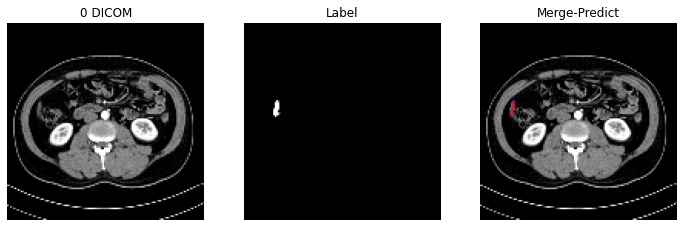

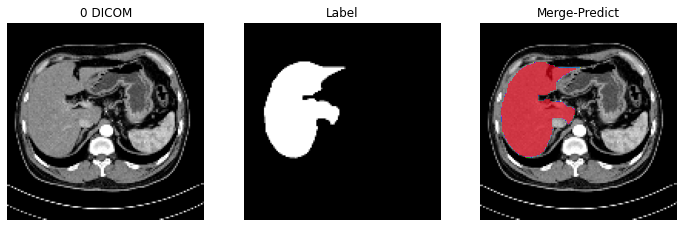

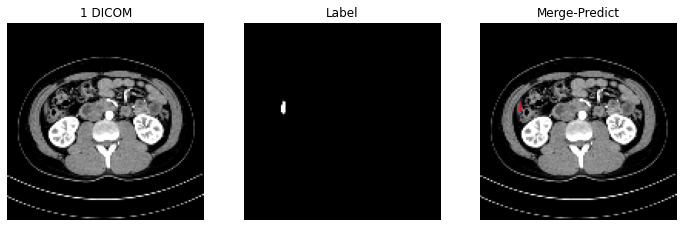

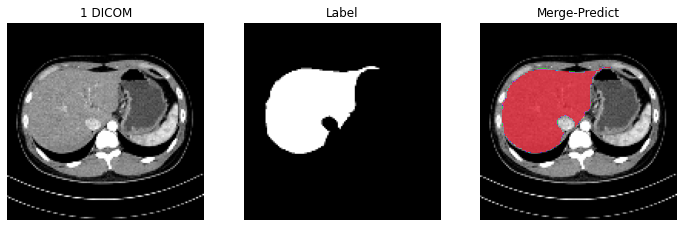

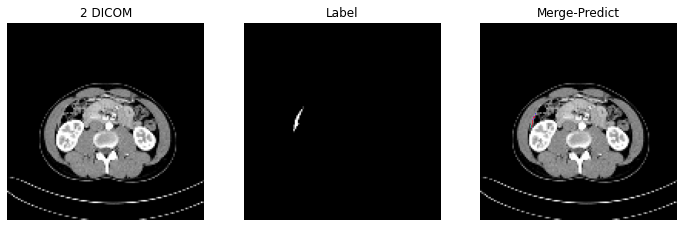

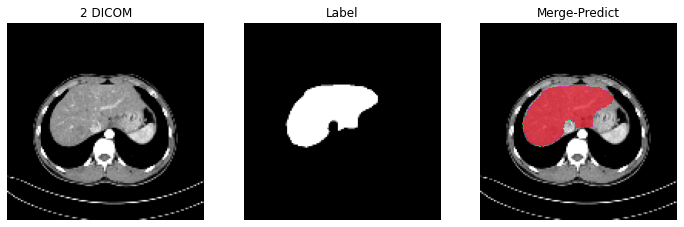

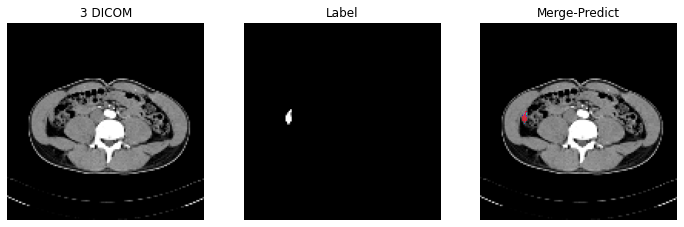

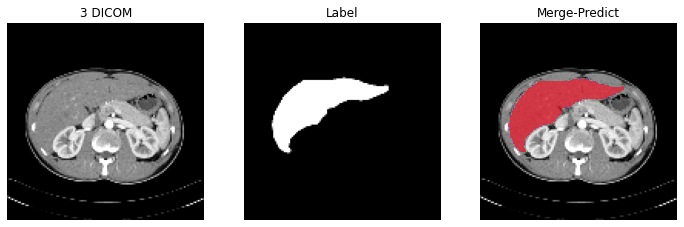

In [14]:
for i in range(0, len(re_pre_img)):
    for j in range(0, len(re_pre_img[i]), 20):
        image = re_pre_img[i,j,:,:,0]
        label = re_pre_lab[i,j,:,:,0]
        if np.sum(label) > 0: 
            fig = plt.figure(figsize=(12, 12))
            
            ax1 = fig.add_subplot(2,3,1)
            ax1.imshow(image,cmap='gray')
            ax1.axis('off')
            ax1.set_title(f'{i} DICOM')
            
            ax2 = fig.add_subplot(2,3,2)
            ax2.imshow(label,cmap='gray')
            ax2.axis('off')
            ax2.set_title('Label')
            
            ax3 = fig.add_subplot(2,3,3)
            ax3.imshow(image,cmap='gray')
            tmpMask = label
            maskedRegion = np.ma.masked_where(tmpMask == 0, tmpMask)
            ax3.imshow(maskedRegion,cmap='hsv' ,alpha=0.6)
            ax3.axis('off')
            ax3.set_title('Merge-Predict')

# Augmentation

In [15]:
def return_ang_sca():
    angle_array = []
    scale_array = []
    
    aug_count = 1
    exist_same = True
    
    while exist_same == True :
        angle_array = np.random.randint(low=-40, high=40, size=(aug_count,)) / 10   # 랜덤 앵글
        scale_array = np.random.randint(low=80, high=100, size=(aug_count,)) / 100  # 랜덤 resize 
    
        dict_angle = {}
        dict_scale = {}
        for i in range(aug_count) :
            dict_angle[str(angle_array[i])] = 1
            dict_scale[str(scale_array[i])] = 1
    
        ang_cnt = len(dict_angle)
        sca_cnt = len(dict_scale)
        if (ang_cnt == sca_cnt and ang_cnt == aug_count) :
            exist_same = False
            break
    
        print(angle_array)
        print(scale_array)
    return angle_array[0], scale_array[0]
    
def return_augmentation(img_arr, lab_arr):
    aang, asca = return_ang_sca()
    
    for i in range(len(img_arr)):
        img = img_arr[i,...,0]
        lab = lab_arr[i,...,0]
        if np.sum(img) == 0:
            continue
        
        img = RotateScaleImage(img, aang, asca)
        lab = RotateScaleImage(lab, aang, asca)
        
        img_arr[i,...,0] = img
        lab_arr[i,...,0] = lab
    return img_arr, lab_arr

# save

In [16]:
def save_nii(arr, path):
    arr = np.swapaxes(arr, 0, 2)
    nii_file = nib.Nifti1Image(arr,None) 
    nib.save(nii_file, path) #.nii파일로 저장
    return

In [20]:
pre_img_dir = f'{save_dir}/niigz/image/pre'
pre_lab_dir = f'{save_dir}/niigz/label/pre'

os.makedirs(pre_img_dir, exist_ok=True)
os.makedirs(pre_lab_dir, exist_ok=True)

for i in tqdm_notebook(range(len(ls_pre_img))):
    pre_fn = pre_list[i].split('/')[-2]
    
    save_nii(ls_pre_img[i], f'{pre_img_dir}/{pre_fn}.nii.gz')
    save_nii(ls_pre_lab[i], f'{pre_lab_dir}/{pre_fn}.nii.gz')


/data01/anaconda3/envs/msb_tensor_1_15/lib/python3.6/site-packages/ipykernel_launcher.py:7: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  import sys


  0%|          | 0/4 [00:00<?, ?it/s]

In [21]:
pre_img_dir = f'{save_dir}/3d_npy/image/pre'
pre_lab_dir = f'{save_dir}/3d_npy/label/pre'

os.makedirs(pre_img_dir, exist_ok=True)
os.makedirs(pre_lab_dir, exist_ok=True)

for i in tqdm_notebook(range(len(re_pre_img))):
    pre_fn = f"{i:02d}_{pre_list[i].split('/')[-2]}"
    
    np.save(f'{pre_img_dir}/{pre_fn}.npy', re_pre_img[i])
    np.save(f'{pre_lab_dir}/{pre_fn}.npy', re_pre_lab[i])


/data01/anaconda3/envs/msb_tensor_1_15/lib/python3.6/site-packages/ipykernel_launcher.py:7: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  import sys


  0%|          | 0/4 [00:00<?, ?it/s]

In [23]:
pre_img_dir = f'{save_dir}/3d_npy_aug/image'
pre_lab_dir = f'{save_dir}/3d_npy_aug/label'

os.makedirs(pre_img_dir, exist_ok=True)
os.makedirs(pre_lab_dir, exist_ok=True)

for i in tqdm_notebook(range(len(re_pre_img))):
    for j in range(aug_cnt):
        pre_fn = f"{i:02d}_{j:02d}_{pre_list[i].split('/')[-2]}"
        aug_pre_img, aug_pre_lab = return_augmentation(re_pre_img[i], re_pre_lab[i])
        np.save(f'{pre_img_dir}/{pre_fn}.npy', aug_pre_img)
        np.save(f'{pre_lab_dir}/{pre_fn}.npy', aug_pre_lab)
        

/data01/anaconda3/envs/msb_tensor_1_15/lib/python3.6/site-packages/ipykernel_launcher.py:7: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  import sys


  0%|          | 0/4 [00:00<?, ?it/s]